In [1]:
import gEconpy as ge
import gEconpy.plotting as gp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from cycler import cycler
from matplotlib.colors import Normalize

In [2]:
mod_cd = ge.model_from_gcn(
    "../GCN Files/RBC_steady_state.gcn", backend="pytensor", mode="JAX", verbose=False
)
mod = ge.model_from_gcn("../GCN Files/RBC_with_CES.gcn", backend="pytensor", mode="JAX")

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	8 parameters
		 0 / 8 has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



## Show that the MRS is equal to $\psi$

In [3]:
globals().update({x.base_name: x.to_ss() for x in mod.variables})
globals().update({x.name: x for x in mod.params})

# Compute derivatives of production function w.r.t inputs
production_fn = ge.utilities.eq_to_ss(mod.equations[5].args[1])
dY_dK = production_fn.diff(K).simplify()
dY_dL = production_fn.diff(L).simplify()

In [4]:
import sympy as sp

# At the optimum, we require dY/dK / r = dY/dL / w
w_res = sp.solve(dY_dK / r - dY_dL / w, w)[0]
ratio = w_res / r
display(sp.Eq(w / r, w_res / r))

V, Z = sp.symbols("V Z", positive=True)
Z_solved = sp.solve((w / r - ratio).subs({w / r: V, K / L: Z}), Z)[0]

display(sp.Eq(K / L, Z_solved.subs({V: w / r})))

# Use indivator variables V, Z to compute MRS = dZ/dV * V / Z
display(sp.Eq(Z, Z_solved))
display(sp.Eq(sp.Symbol("MRS"), (Z_solved.diff(V) * V / Z).subs({Z: Z_solved})))

Eq(w_ss/r_ss, (K_ss*(1 - alpha)/(alpha*L_ss))**(1/psi))

Eq(K_ss/L_ss, -alpha*(w_ss/r_ss)**psi/(alpha - 1))

Eq(Z, -V**psi*alpha/(alpha - 1))

Eq(MRS, psi)

# Compare CES to Cobb Douglass

In [5]:
cd_production_fn = mod_cd.equations[5].args[1]

In [6]:
f_ces = sp.lambdify([psi, alpha, A, K, L], production_fn)
adjustment_factor = (1 - alpha) ** (alpha - 1) / alpha**alpha
f_cd = sp.lambdify(
    [alpha, A, K, L], ge.utilities.eq_to_ss(adjustment_factor * cd_production_fn)
)

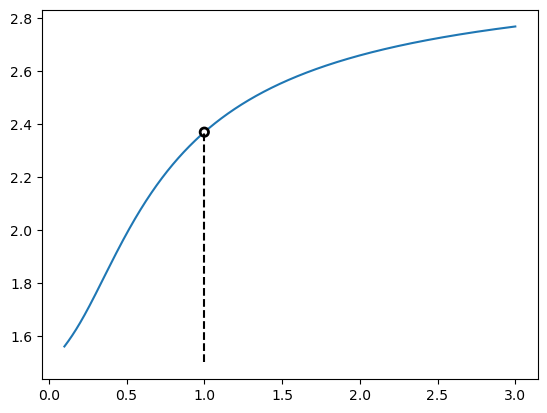

In [7]:
psis = np.linspace(0.1, 3, 10000)
fig, ax = plt.subplots()
Y_ces = f_ces(psis, 0.33, 1, 2, 1)
ax.plot(psis[psis < 0.97], Y_ces[psis < 0.97], color="tab:blue")
ax.plot(psis[psis > 1.03], Y_ces[psis > 1.03], color="tab:blue")
ax.scatter(1.0, f_cd(0.33, 1, 2, 1), lw=2, facecolor="none", edgecolor="k", zorder=100)
ax.vlines(1.0, ax.get_ylim()[0], f_cd(0.33, 1, 2, 1), ls="--", color="k")
plt.show()

# Maximum Value of $\psi$

The equation for $N_{ss}$, the steady-state capital-labor ratio, is:

$$N_{ss} = \left ( \frac{\left ( \frac{1}{\beta} - (1 - \delta) \right ) ^{\psi - 1} \alpha ^ {\frac{1 - \psi}{\psi}}  (A_{ss} mc_{ss}) ^ {1 - \psi} - \alpha ^ {\frac{1}{\psi}}}{(1 - \alpha) ^ {\frac{1}{\psi}}} \right) ^ {\frac{\psi}{1 - \psi}}$$

This needs to be strictly positive. It is possible to have negative values in the numerator, when:

$$\left ( \frac{1}{\beta} - (1 - \delta) \right ) ^{\psi - 1} \alpha ^ {\frac{1 - \psi}{\psi}}  (A_{ss} mc_{ss}) ^ {1 - \psi} \lt \alpha ^ {\frac{1}{\psi}} $$

In [8]:
psi_zero = sp.solve(
    sp.Eq(
        (1 / beta - (1 - delta)) ** (psi - 1) * alpha ** ((1 - psi) / psi),
        alpha ** (1 / psi),
    ),
    psi,
)[0]

In [9]:
psi_zero

(log(beta/alpha) - log(beta*delta - beta + 1))/(log(beta) - log(beta*delta - beta + 1))

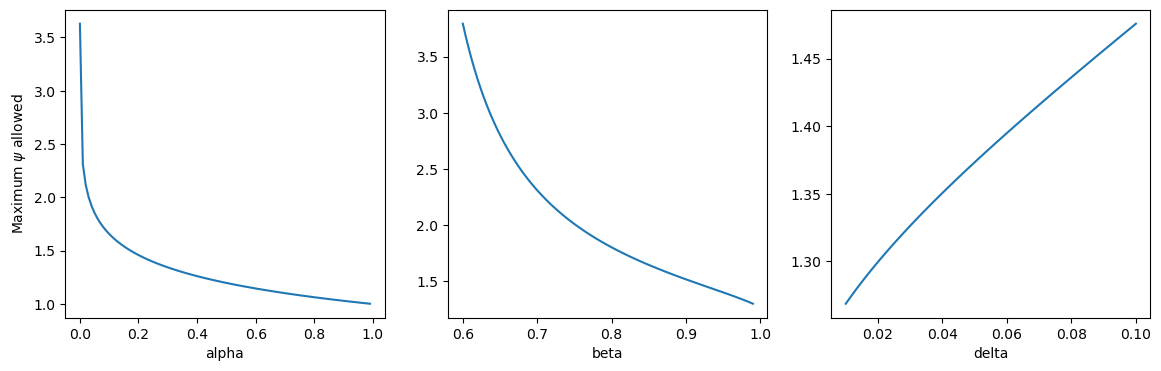

In [10]:
f = sp.lambdify([alpha, beta, delta], psi_zero)
alphas = np.linspace(1e-4, 0.99, 100)
betas = np.linspace(0.6, 0.99, 100)
deltas = np.linspace(0.01, 0.1, 100)
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for axis, var, values in zip(
    fig.axes, ["alpha", "beta", "delta"], [alphas, betas, deltas]
):
    input_dict = mod.parameters().copy()
    input_dict[var] = values
    axis.plot(
        values,
        f(
            alpha=input_dict["alpha"],
            beta=input_dict["beta"],
            delta=input_dict["delta"],
        ),
    )
    axis.set(xlabel=var)
    if axis == fig.axes[0]:
        axis.set_ylabel(r"Maximum $\psi$ allowed")
plt.show()

In [11]:
psi_zero.subs(mod.parameters().to_sympy())

1.29967548484066

In [12]:
psis = np.linspace(0.1, 1.2, 50)
df = pd.DataFrame({psi: mod.steady_state(psi=psi) for psi in psis}).T

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


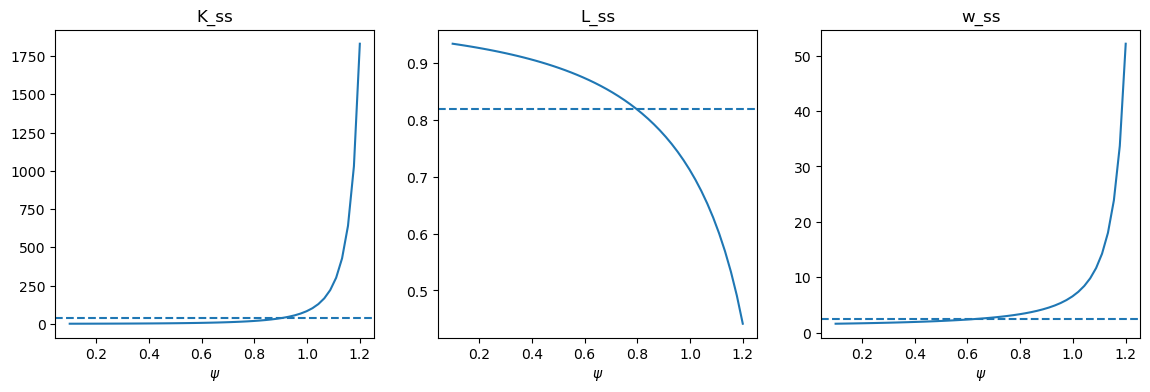

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, var in enumerate(["K_ss", "L_ss", "w_ss"]):
    df.plot.line(y=var, ax=ax[i], legend=False)
    ax[i].axhline(mod_cd.steady_state()[var], ls="--")
    ax[i].set(title=var, xlabel=r"$\psi$")

In [14]:
irfs = [
    ge.impulse_response_function(
        mod, psi=psi, shock_size={"epsilon_A": 0.1}, verbose=False
    )
    for psi in psis
]
irfs = xr.concat(irfs, coords="all", dim="psi").assign_coords(psi=psis)

# Effect of $\psi$ on IRF

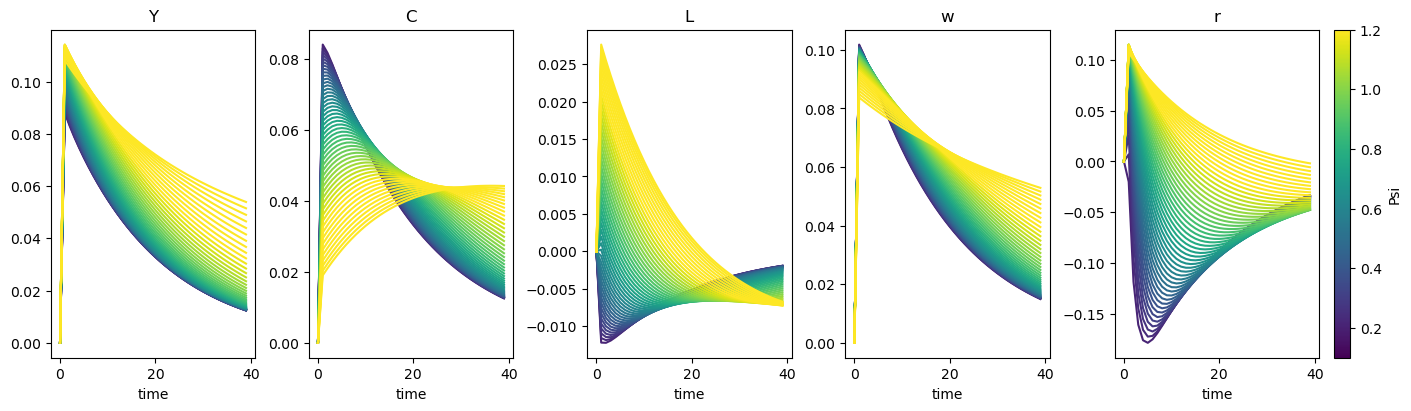

In [15]:
norm = Normalize(vmin=psis.min(), vmax=psis.max())
cmap = plt.get_cmap("viridis")

fig, ax = plt.subplots(1, 5, figsize=(14, 4), layout="constrained")
for axis, variable in zip(fig.axes, ["Y", "C", "L", "w", "r"]):
    axis.set_prop_cycle(cycler("color", [plt.colormaps["viridis"](i) for i in psis]))
    irfs.sel(variable=variable, shock="epsilon_A").plot.line(
        x="time", hue="psi", add_legend=False, ax=axis
    )
    axis.set_title(variable)

    if axis == fig.axes[-1]:
        sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
        cbar = fig.colorbar(sm, ax=axis)
        cbar.set_label("Psi")

plt.show()